In [1]:
#loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from pandas import DataFrame
import joblib

In [2]:
#https://www.kaggle.com/code/danhoang/loan-default-prediction-using-ann-keras helped me choose the right values from the above 50 columns :D thanks to this guy, gave me alot of pointers on the data
df = pd.read_csv('data/accepted.csv',low_memory=False)
df = df[['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length',
        'home_ownership','annual_inc','verification_status','issue_d','loan_status','purpose',
        'title','dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util',
        'total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies']]

df = df[(df['loan_status']=='Fully Paid') | (df['loan_status']=='Charged Off')]
df = df.iloc[:,0:5000]

In [26]:
df['dti'].mean()

19.06308972340904

In [20]:
#checking length of dataframe to make sure all the slicing was succeful
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4447 entries, 0 to 4992
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             4447 non-null   int64  
 1   term                  4447 non-null   int64  
 2   int_rate              4447 non-null   float64
 3   installment           4447 non-null   float64
 4   sub_grade             4447 non-null   int64  
 5   emp_length            4447 non-null   int64  
 6   annual_inc            4447 non-null   float64
 7   loan_status           4447 non-null   int64  
 8   dti                   4447 non-null   float64
 9   earliest_cr_line      4447 non-null   int64  
 10  open_acc              4447 non-null   int64  
 11  pub_rec               4447 non-null   int64  
 12  revol_bal             4447 non-null   int64  
 13  revol_util            4447 non-null   float64
 14  total_acc             4447 non-null   int64  
 15  mort_acc             

In [4]:
#converting the possible Y table to 1s and 0zeros 
Y_loan_status = df["loan_status"].to_list()
Y_loan_status_new = []
for i in Y_loan_status:
    if i == "Fully Paid":
        Y_loan_status_new.append(1)
    else:
        Y_loan_status_new.append(0)
df.drop(['loan_status'],axis='columns')
df['loan_status'] = Y_loan_status_new


In [5]:
#we have to do the same thing to terms tab
term_to_list = df["term"].to_list()
term_to_list_new = []
for i in term_to_list:
    if i == ' 36 months':
        term_to_list_new.append(36)
    else:
        term_to_list_new.append(60)
df['term'] = term_to_list_new


In [6]:
#now to time for emp_length emp_length            
emp_length = df["emp_length"].to_list()
emp_length_new = []
for i in emp_length:
    if i == '10+ years':
        emp_length_new.append(10)
    elif  i == '< 1 year':
        emp_length_new.append(1)
    elif str(i) == 'nan':
        emp_length_new.append(0)
    else:
        emp_length_new.append(int(str(i)[0]))


df['emp_length'] = emp_length_new


In [ ]:
print(df["emp_length"][0:10])

In [ ]:
#now we need to check null values, we dealt with some in emp_length but lets see the whole picture
df.isnull().sum()
#running the following codes we can see the data is ready to put into the model now

In [9]:
#lets remove EMP_title and grade, we dont need emp_title as there is too many variations of it to convert it to numeric data and grade is a simpler copy of grade
df['title'].value_counts()
df['title'].nunique()
#there is way too many variations in strings to convert this to int so we can remove this too
df = df.drop(['grade','emp_title','title'],axis = 1)

In [10]:
#idk why its showing nulls in mort_acc
#its just go through the data and feed it again as int
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

mort_acc = df["mort_acc"].to_list()
mort_acc_new = []
for i in mort_acc:
    if isfloat(i):
        try:
            mort_acc_new.append(int(i)+1)
        except:
            mort_acc_new.append(1)
    else:
        mort_acc_new.append(1)
df['mort_acc'] = mort_acc_new


In [ ]:
#we we can see the strong relatives between variables like installment and loan amount
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.tight_layout()

In [12]:
#found a shorter way to do it other than converting it to list and adding it to the dataframe again we can just do everything in the same line
#thanks to the guy who did work on this dataset helped me alot
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: int(x.split("-")[-1]))


In [13]:
#lastly we have grade, or sub grade
#converting it to usable data will be tricky
#for now before making the model we can convert it and test the model with and without it to check if it helps us or not
#VALUES range from A to G,given A is 'good' and g is well 'not good' we can assign numercal aphlas the excisting side values forxample A5 will be 55 and G4 04
#lets start
sub_grades_list = df['sub_grade'].to_list()
sub_grades_list_new = []
weights = {'G':0,'F':10,'E':20,'D':30,'C':40,'B':50,'A':60}
for i in sub_grades_list:
    grade = str(i)
    sub_grades_list_new.append(weights[grade[0]]+int(grade[1]))
#print(sub_grades_list_new)
#it works now lets change the data in the main dataframe
df['sub_grade'] = sub_grades_list_new

In [14]:
#now we have enough numerical data for the model
#lets start with basic nearest neighbour to process the data
#first we can drop all the string rows that will not help us in the model
#
df = df.drop(['home_ownership','verification_status','issue_d','purpose','initial_list_status','application_type'],axis = 1)
#finally there is no string data just numeric data for the model

In [15]:
#filling null values with zero as it is causing problems in pyspacrk
df.fillna(df.mean(), inplace=True)

In [13]:
#using pyspark library from the help of https://www.datatechnotes.com/2021/06/pyspark-decision-tree-classification.html
# from pyspark import SparkContext
# from pyspark.sql import SQLContext
# from pyspark.sql import SparkSession
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml.feature import VectorAssembler

#I CANT FIND ANY LIBRARIES THAT ARE SUPPORTED BY PYSPARK FOR EXPLAINABILITY SO I HAVE TO SKLEARN FOR THE MODEL, THIS IS THE PREVIOUS MODEL

# sc = SparkContext().getOrCreate()
# sqlContext = SQLContext(sc)

# data = sqlContext.createDataFrame(df)
# print(data.printSchema()) 
# va = VectorAssembler(inputCols = ['loan_amnt','term','int_rate','annual_inc','open_acc','earliest_cr_line','dti','mort_acc','pub_rec_bankruptcies','revol_util'], outputCol='features')
# #installment and sub grade were reducing accuracy so they were dropped, sub grade changed the accuracy from 72 to 73
# # 'pub_rec','revol_bal <- these rows bad too 
# # 'total_acc' total account not really helping
# va_df = va.transform(data)
# va_df = va_df.select(['features', 'loan_status'])

# (train, test) = va_df.randomSplit([0.8, 0.2])
# dtc = DecisionTreeClassifier(featuresCol="features", labelCol="loan_status")
# dtc = dtc.fit(train)

# pred = dtc.transform(test)
# pred = pred.selectExpr( "features as features","loan_status as label","rawPrediction as rawPrediction","probability as probability","prediction as prediction")
# evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
# acc = evaluator.evaluate(pred)
 
# print("Prediction Accuracy: ", acc)
 
# y_pred=pred.select("prediction").collect()
# y_orig=pred.select("label").collect()

# cm = confusion_matrix(y_orig, y_pred)
# print("Confusion Matrix:")
# print(cm)
#ITS WORKKING but accuracy not great. i can defo try with dropping some useless values and try again
#UPDATE changed values and dropped some rows now acc close to 80 cant really go higher than that by changing stuff. so 80% is good



In [16]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split


C:\Users\muham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1 Train score: 0.8189485521506887 Test score: 0.8101123595505618
2 Train score: 0.8189485521506887 Test score: 0.8101123595505618
3 Train score: 0.8214787742479618 Test score: 0.8191011235955056
4 Train score: 0.8313185268484679 Test score: 0.8168539325842696
5 Train score: 0.8375035141973574 Test score: 0.8157303370786517
6 Train score: 0.8490300815293786 Test score: 0.8089887640449438
7 Train score: 0.8625245993815013 Test score: 0.7921348314606742
8 Train score: 0.875737981445038 Test score: 0.7865168539325843
9 Train score: 0.8951363508574641 Test score: 0.7674157303370787


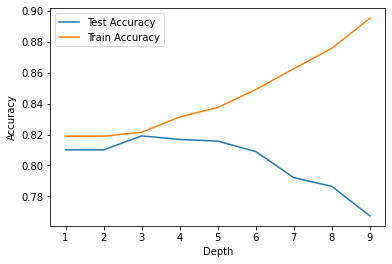

In [17]:
X = df.drop('loan_status',axis = 'columns').values
y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Prepares a default instance of the random forest regressor
train_acc=[]
test_acc=[]
list_score=[]
p=[]

for i in range(1, 10):
    
    dtc = DecisionTreeClassifier(max_depth = i ,random_state = 0)
    dtc.fit(X_train, y_train)

    train_pred = dtc.predict(X_train)
    #train_acc.append(score(train_pred, yTrain))
    
    test_pred = dtc.predict(X_test)
    #test_acc.append(score(test_pred, yTest))
    test_acc = accuracy_score(y_test, test_pred)
    train_acc = accuracy_score(y_train, train_pred)
    print(i,'Train score:',train_acc,'Test score:',test_acc)

    list_score.append([i,accuracy_score(train_pred, y_train),accuracy_score(test_pred, y_test)]) 
    
    
df2 = DataFrame (list_score,columns=['Depth','Train Accuracy','Test Accuracy'])
plt.plot(df2['Depth'],df2['Test Accuracy'],label='Test Accuracy')
plt.plot(df2['Depth'],df2['Train Accuracy'],label='Train Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()  
#so we can see the best accuracy is at 4 depth of the tree
#find this classifier on https://medium.com/@amansangal9/predicting-credit-card-approvals-8409c5280f91


In [18]:
dtc = DecisionTreeClassifier(max_depth = 4 ,random_state = 0)
dtc.fit(X_train, y_train)

train_pred = dtc.predict(X_train)
    #train_acc.append(score(train_pred, yTrain))
    
test_pred = dtc.predict(X_test)
    #test_acc.append(score(test_pred, yTest))
test_acc = accuracy_score(y_test, test_pred)
train_acc = accuracy_score(y_train, train_pred)
print('Train score:',train_acc,'Test score:',test_acc)
#now we have the model lets use SHAP library to get the needed graphs


Train score: 0.8313185268484679 Test score: 0.8168539325842696


In [34]:
# Fits the explainer
explainer = shap.Explainer(dtc.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values)

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

In [ ]:
shap.plots.waterfall(shap_values[0])

In [19]:
filename = 'finalized_model.sav'
joblib.dump(dtc, filename)

['finalized_model.sav']

In [ ]:
df.info()